# Deep learning -  Opdracht sessie 01 - neurale netwerken

## Doelstelling van de opdracht

Deep learning is onovertroffen in het extraheren van informatie uit grote hoeveelheden data. Als subdomein binnen de machine learning zorgt het ervoor dat praktische toepassingen die vroeger als sciencefiction werden beschouwd realiteit worden. Denk maar aan betere preventieve gezondheidszorg, self-driving cars, performante recommendation systems, CSI style beeldverwerking, machine translations, etc.

De onderliggende technologie van de verschillende deep learning architecturen zijn de zogenaamde neurale netwerken.
Het is daarom essentiëel een goed inzicht te verkrijgen in de mechanismen en parameters van deze neurale netwerken.

Bij deze opdracht zullen feedforward neurale netwerken in Keras worden gebouwd voor het uitvoeren van classificatietaken.

De warm-up oefening is vooral bedoeld om inzicht te verkrijgen in de invloed en rol van de verschillende hyperparameters. Deze oefening wordt stap voor stap opgebouwd. Belangrijk zijn niet zozeer de uiteindelijk accuracy cijfers, maar de conclusies en inzichten die in dit document worden neergeschreven.

Bij de andere oefeningen wordt van de student verwacht om zelfstandig een performante pipeline te kunnen opzetten van ruwe data tot en met een performante classificatie.


In [196]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.image as mpimg
from skimage.io import imread, imshow

# distributions
from scipy.stats import randint 
from scipy.stats import uniform


# Import Keras libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adamax
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import RandomUniform, Ones, Zeros, RandomNormal
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

###### Voor Tensorflow-GPU ########

#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
print(tf.__version__)
if tf.__version__.split('.')[0]!='2':
    raise ImportError("Need tensorflow 2")

2.1.0


## Warm-up

Hieronder worden 1000 random samples gegenereerd (getrokken uit vier Gaussiaanse verdelingen). De data bestaat uit 2 features en elke sample behoort tot één van de vier klasses.
Gebruik deze data om een neuraal netwerk te trainen dat als classifier optreedt.
De volledige datapipeline van deze opdracht is hieronder beschikbaar. De bedoeling is om de invloed van de hyperparameters uit te testen en de conclusies neer te schrijven in dit document. De vragen kan je onder de voorbeeldcode terugvinden.

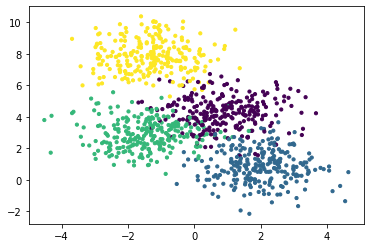

In [3]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=1000, centers=4, center_box = [-10,10],
                  random_state=0, cluster_std=1)
plt.scatter(X[:, 0], X[:, 1], s=10,c=y);

In [4]:
# splitsen in test set en training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =0)

# ---------------------------------------------------
# normaliseren van de input data

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#----------------------------------------------------
# one-hot encoding op output
y_train = to_categorical(y_train)
print(y_train)
print(y_train.shape)

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
(800, 4)


In [249]:
# NN parameters

def CreateModel(inputs, outputs, hidden_layers = [],
                initializer = RandomUniform(seed=12345), activation = 'relu', output_activation = 'softmax',
                optimizer = Adam(), 
                extra_name = 'adam'):
    model = Sequential()
    if hidden_layers:
        for i,l in enumerate(hidden_layers):
            if l[0]=='dense':
                model.add(Dense(l[1], input_dim=inputs if i==0 else None, kernel_initializer=initializer, activation=activation))
            elif l[0] == 'dropout':
                model.add(Dropout(l[1]))
            elif l[0] == 'batchnorm':
                model.add(BatchNormalization())
            else:
                raise NotImplementedError("layer type %s not implemented"%l[0])
        model.add(Dense(outputs, kernel_initializer=initializer, activation=output_activation))
    else:
        #model without hiffen layers
        model.add(Dense(outputs, input_dim=inputs, kernel_initializer=initializer, activation=output_activation))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    
    def layer_id(l):
        if l[0] in ['dense', 'dropout']:
            return str(l[1])
        elif l[0] == 'batchnorm':
            return 'bn'
        else:
            return 'NaL'
    
    name = [ layer_id(l) for l in layers ]  
    name = '-'.join(name) + '-' + activation + '-' + extra_name
    
    return model, name

layers = [ ['dense', 20], 
           ['dense', 20],
           ['dense', 20],
         ]
model1, name1 = CreateModel(X_train.shape[1], y_train.shape[1], hidden_layers=layers, extra_name="adam")

model1.summary()
#plot_model(model, 'model.png', show_shapes=True)


Model: "sequential_245"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_993 (Dense)            (None, 20)                60        
_________________________________________________________________
dense_994 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_995 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_996 (Dense)            (None, 4)                 84        
Total params: 984
Trainable params: 984
Non-trainable params: 0
_________________________________________________________________


In [250]:
# train the model
batch_size = 32
epochs = 150
history1 = model1.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=1)

Train on 640 samples, validate on 160 samples
Epoch 1/150
640/640 [==============================] - 0s 491us/sample - loss: 1.3862 - accuracy: 0.2438 - val_loss: 1.3854 - val_accuracy: 0.2250
Epoch 2/150
640/640 [==============================] - 0s 50us/sample - loss: 1.3818 - accuracy: 0.4266 - val_loss: 1.3757 - val_accuracy: 0.4563
Epoch 3/150
640/640 [==============================] - 0s 45us/sample - loss: 1.3581 - accuracy: 0.4984 - val_loss: 1.3287 - val_accuracy: 0.4563
Epoch 4/150
640/640 [==============================] - 0s 49us/sample - loss: 1.2740 - accuracy: 0.4984 - val_loss: 1.2042 - val_accuracy: 0.4563
Epoch 5/150
640/640 [==============================] - 0s 55us/sample - loss: 1.1077 - accuracy: 0.4984 - val_loss: 1.0317 - val_accuracy: 0.4563
Epoch 6/150
640/640 [==============================] - 0s 49us/sample - loss: 0.9476 - accuracy: 0.4984 - val_loss: 0.9292 - val_accuracy: 0.4563
Epoch 7/150
640/640 [==============================] - 0s 48us/sample - loss:

Epoch 112/150
640/640 [==============================] - 0s 43us/sample - loss: 0.1485 - accuracy: 0.9359 - val_loss: 0.1808 - val_accuracy: 0.9250
Epoch 113/150
640/640 [==============================] - 0s 43us/sample - loss: 0.1483 - accuracy: 0.9375 - val_loss: 0.1849 - val_accuracy: 0.9312
Epoch 114/150
640/640 [==============================] - 0s 42us/sample - loss: 0.1480 - accuracy: 0.9375 - val_loss: 0.1813 - val_accuracy: 0.9250
Epoch 115/150
640/640 [==============================] - 0s 42us/sample - loss: 0.1460 - accuracy: 0.9359 - val_loss: 0.1830 - val_accuracy: 0.9312
Epoch 116/150
640/640 [==============================] - 0s 53us/sample - loss: 0.1484 - accuracy: 0.9406 - val_loss: 0.1800 - val_accuracy: 0.9250
Epoch 117/150
640/640 [==============================] - 0s 44us/sample - loss: 0.1483 - accuracy: 0.9344 - val_loss: 0.1803 - val_accuracy: 0.9312
Epoch 118/150
640/640 [==============================] - 0s 42us/sample - loss: 0.1537 - accuracy: 0.9344 - val_

Figure(864x432)


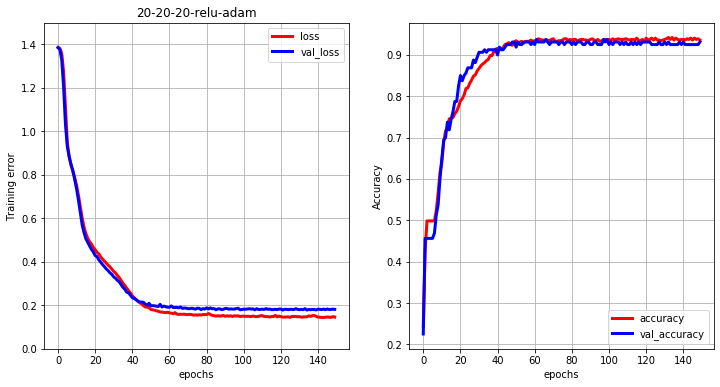

In [251]:
# Plot history
def histplot(history, name):
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    print(fig)

    #axs[0].rcParams['axes.labelsize'] = 15
    axs[0].plot(history.history['loss'],'red',linewidth=3.0, label="loss")
    axs[0].plot(history.history['val_loss'],'blue',linewidth=3.0, label="val_loss")
    axs[0].legend()
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('Training error')
    axs[0].set_ylim((0,1.5))
    axs[0].grid()
    axs[0].set_title(name)

    #axs[1].rcParams['axes.labelsize'] = 15
    axs[1].plot(history.history['accuracy'],'red',linewidth=3.0, label="accuracy")
    axs[1].plot(history.history['val_accuracy'],'blue',linewidth=3.0, label="val_accuracy")
    axs[1].legend()
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].grid()
    fig.savefig(name+'.png')

histplot(history1, name1)    

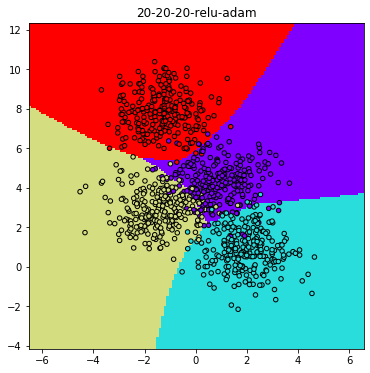

In [252]:
# Plotten van de decision boundary
def boundary(model, name):
    plt.figure(figsize=(6,6))
    h = 0.1
    x1_min = X[:,0].min()-2
    x1_max = X[:,0].max()+2
    x2_min = X[:,1].min()-2
    x2_max = X[:,1].max()+2
    xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),np.arange(x2_min, x2_max, h))

    xy = np.vstack([xx.ravel(), yy.ravel()]).T

    #xys = xy
    xys = scaler.transform(xy)

    try:
        Zn = model.predict_classes(xys).reshape(xx.shape)
    except:
        Zn = model.predict(xys).reshape(xx.shape)

    plt.pcolormesh(xx,yy, Zn,cmap='rainbow')
    plt.scatter(X[:, 0], X[:, 1], c=y,edgecolor='k', s=20,cmap='rainbow')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.gca().set_title(name)
    plt.gcf().savefig(name+"boundary.png")
    
boundary(model1, name1)

In [62]:
# Testen met test set
y_pred = model1.predict_classes(X_test)

print(classification_report(y_test, y_pred))
cf = confusion_matrix(y_test, y_pred)

print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

              precision    recall  f1-score   support

           0       0.81      0.77      0.79        44
           1       0.96      0.96      0.96        51
           2       0.86      0.88      0.87        48
           3       0.97      0.98      0.97        57

   micro avg       0.91      0.91      0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.91      0.90       200

[[34  2  6  2]
 [ 1 49  1  0]
 [ 6  0 42  0]
 [ 1  0  0 56]]
90.5


### Opdrachten warm-up oefening

1. Varieer bij SGD de learning rate en onderzoek wat er gebeurt wanneer deze te klein of te groot wordt. Wat is de invloed van normalisatie op de learning rate en de plot van de model loss?
2. Probeer verschillende optimizers uit: SGD, Adam, RMSProp, Adagrad, ... (https://keras.io/optimizers/). Kijk wat er gebeurt in termen van de model loss curve en de accuracy.
3. Kies een dropoutrate van 0.8. Verklaar wat er gebeurt. Zet nadien de dropout rate terug naar 0.0
4. Verhoog het aantal neuronen in de hidden layers. Wat is de invloed daarvan?
5. Verhoog het aantal hidden layers. Wat merk je? Bekijk de decision boundary. Controleer of je met overfitting te maken hebt. Verhoog nu de dropout rate. Verklaar wat er gebeurt.
6. Bespreek de invloed van batchnormalization.
7. Probeer verschillende activatiefuncties uit bij de hidden layers. (https://keras.io/activations/)
8. Probeer verschillende initializers. (https://keras.io/initializers/)
9. Doe hyperparameter tuning via grid search, random search en bayes optimization. Wat is de finale accuracy die je haalt op de test set?


In [10]:
# Uitwerking van de opdrachten


## 1. SGD

Figure(864x432)
Figure(864x432)
Figure(864x432)
Figure(864x432)
Figure(864x432)


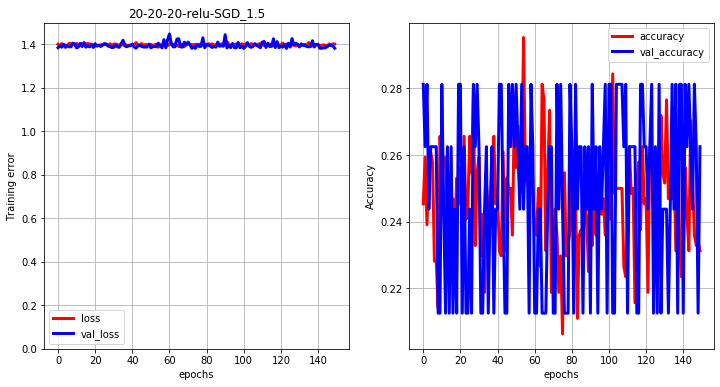

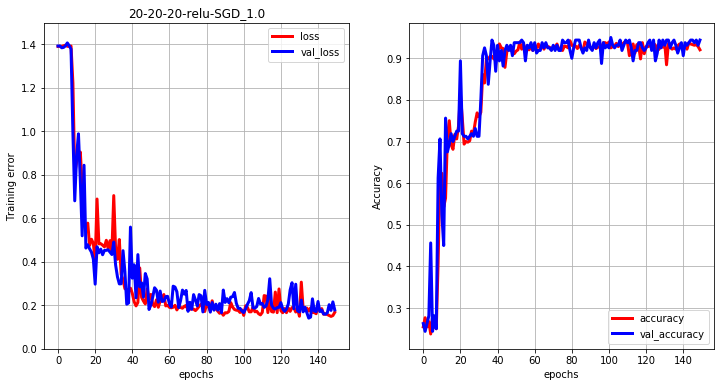

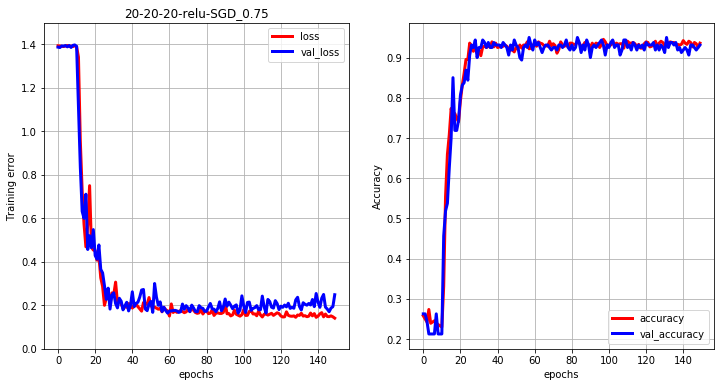

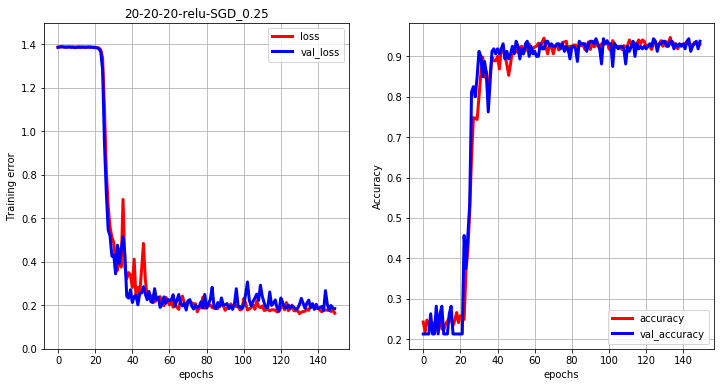

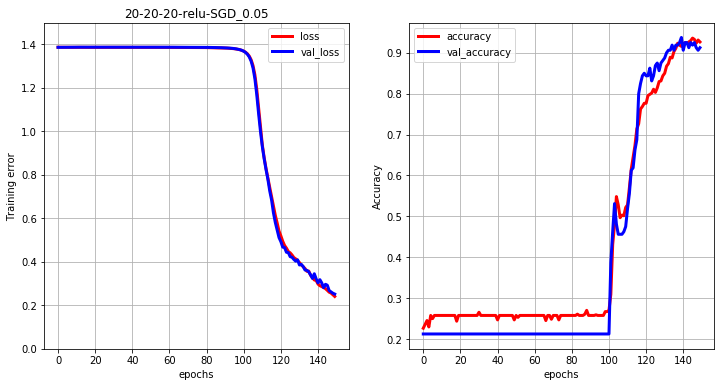

In [66]:
layers = [ ['dense', 20], 
           ['dense', 20], 
           ['dense', 20],
         ]

for lr in [1.5, 1.0, 0.75, 0.25, 0.05]:
    model2, name2 = CreateModel(X_train.shape[1], y_train.shape[1], hidden_layers=layers, 
                              optimizer=SGD(lr=lr), extra_name="SGD_%s"%lr)
    epochs = 150
    history2 = model2.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
    histplot(history2, name2)  

- bij varieren van de learning rate wordt volgende geobserveerd:
    - hogere learning rate (1.5) : chaotisch gedrag van training-loss, de weigths worden te sterk bijgeteld, we schieten het optimum continue voorbij zonder nog echt dichter te komen bij een goede oplossing
    - gemiddelde learning rate (0.25 - 1.0) : gedrag wordt stabieler naarmate de learning rate zakt. We gaan consequenter naar beneden met de training loss. Het trainen wordt trager en trager naarmate de learning rate lager wordt. 
    - kleine learning rate (0.05) : het trainen gaat zeer traag. Zelfs na 150 epochs is de minimum loss nog niet bereikt.

## 2. verschillende optimizers



Figure(864x432)


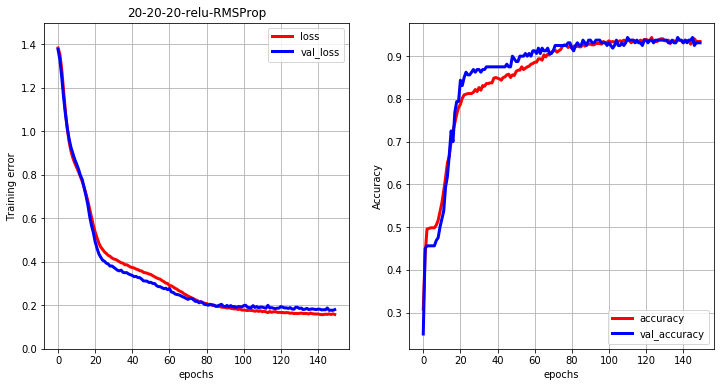

In [71]:
#RMS prop
layers = [ ['dense', 20], 
           ['dense', 20], 
           ['dense', 20],
         ]

model3, name3 = CreateModel(X_train.shape[1], y_train.shape[1], hidden_layers=layers, 
                          optimizer=RMSprop(), extra_name="RMSProp")
epochs = 150
history3 = model3.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
histplot(history3, name3)  

Figure(864x432)


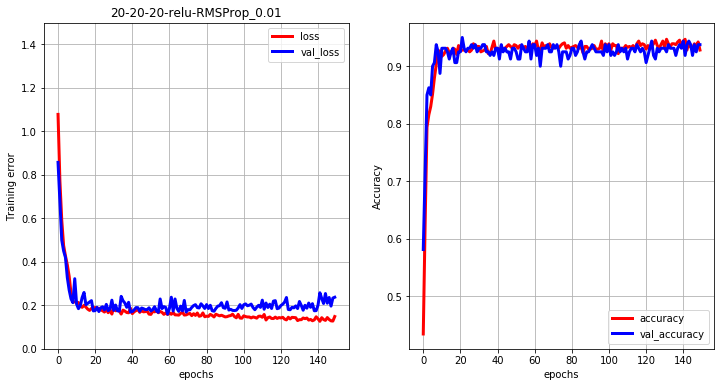

In [72]:
#RMS prop
layers = [ ['dense', 20], 
           ['dense', 20], 
           ['dense', 20],
         ]

model4, name4 = CreateModel(X_train.shape[1], y_train.shape[1], hidden_layers=layers, 
                          optimizer=RMSprop(learning_rate=0.01), extra_name="RMSProp_0.01")
epochs = 150
history4 = model4.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
histplot(history4, name4)  

Figure(864x432)


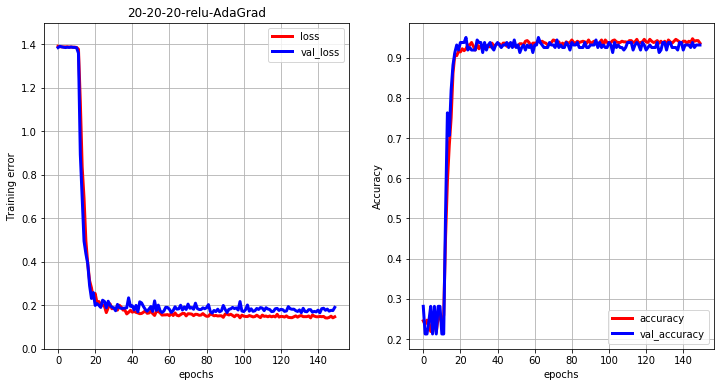

In [79]:
#AdaGrad
layers = [ ['dense', 20], 
           ['dense', 20], 
           ['dense', 20],
         ]

model5, name5 = CreateModel(X_train.shape[1], y_train.shape[1], hidden_layers=layers, 
                          optimizer=Adagrad(learning_rate=0.2), extra_name="AdaGrad")
epochs = 150
history5 = model5.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
histplot(history5, name5)  

Figure(864x432)


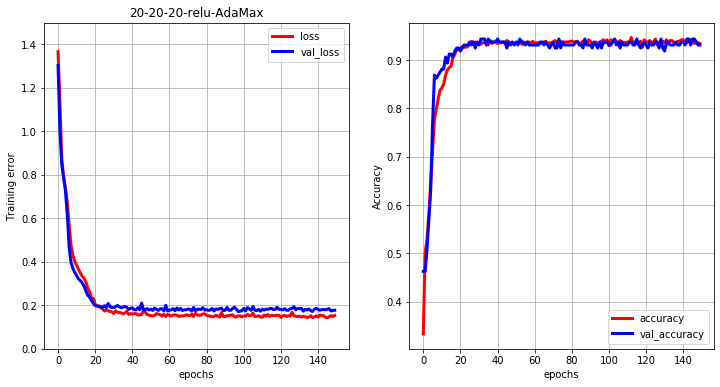

In [84]:
#AdaMax
layers = [ ['dense', 20], 
           ['dense', 20], 
           ['dense', 20],
         ]

model6, name6 = CreateModel(X_train.shape[1], y_train.shape[1], hidden_layers=layers, 
                          optimizer=Adamax(learning_rate=0.01), extra_name="AdaMax")
epochs = 150
history6 = model6.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
histplot(history6, name6)  

- SGD werd reeds uitgevoerd hierboven : 
    - instellen van learning rate is een manuele actie, we hebben een aantal iteraties nodig om een goeie waarde te vinden
- Adam : werd ook reeds toegepast in het initiele voorbeeld : 
    - de learning curve gaat snel en consequent naar beneden. 
    - Er wordt zonder verdere moeilijkheden direct een goede oplossing gevonden
- RMSProp :
    - zonder verdere tuning geeft deze ook een goed resultaat (cfr Adam)
    - met de learning rate parameter wat hoger in te stellen dan de default (0.01 ipm 0.001) wordt nog veel sneller getraind, zonder instabiel gedrag
- Adagrad :
    - volgens de documentatie wordt aangeraden de standaard learning rate van 0.01 te gebruiken, echter dit werd verhoogt tot 0.2 om toch in een redelijk tempo te trainen. Bij de default setting van 0.01 komt de training na 150 epochs nog niet op gang. 
- AdaMax : 
    - ook bij deze optimizer wrdt de learning rate ietwat verhoogt in vergelijking met de default parameters.
    

Al de geteste optimizers bereiken uiteindelijk een gelijkaardig minimum voor de training loss, en een zelfde accuracy. Echter enkel de Adam optimizer kan dit zonder enige inmenging in de default settings van dit algoritme. Adam zal zelfstandig een goede learning rate vinden om op een snelle manier, en zonder teveel uitslingeringen naar het minmum van de loss functie toe te werken.  
   

## 3. Dropout


Figure(864x432)


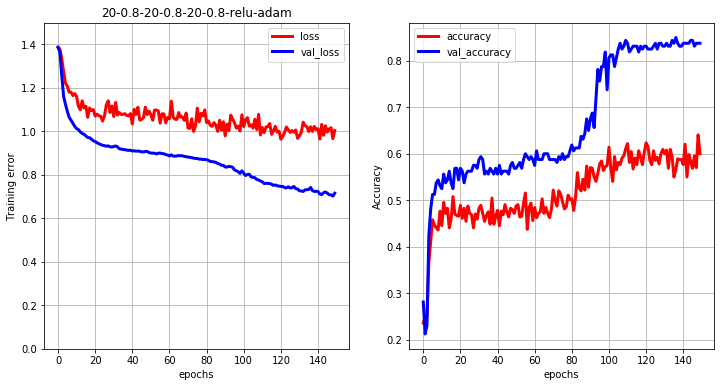

In [89]:
dropout = 0.8

layers = [ ['dense', 20], ["dropout", dropout], 
           ['dense', 20], ["dropout", dropout],
           ['dense', 20], ["dropout", dropout],
         ]

model7, name7 = CreateModel(X_train.shape[1], y_train.shape[1], hidden_layers=layers)
epochs = 150
history7 = model7.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
histplot(history7, name7)  

Met een dropout van 0.8 kan het model niet meer goed getrained worden. De training loss blijft een stuk hoger dan ~0.2 zoals te zien zonder dropout.
Ook de accuracy is gedaald. (de validation accuracy is wel een stuk groter dan de training accuracy! todo : hoe kan dit verklaard worden?)


## 4. Meer neuronen in hidden layers


Figure(864x432)


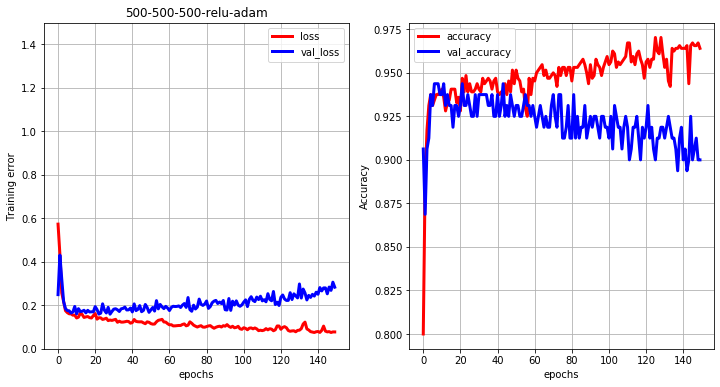

In [91]:
layers = [ ['dense', 500], 
           ['dense', 500], 
           ['dense', 500],
         ]

model8, name8 = CreateModel(X_train.shape[1], y_train.shape[1], hidden_layers=layers)
epochs = 150
history8 = model8.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
histplot(history8, name8)  

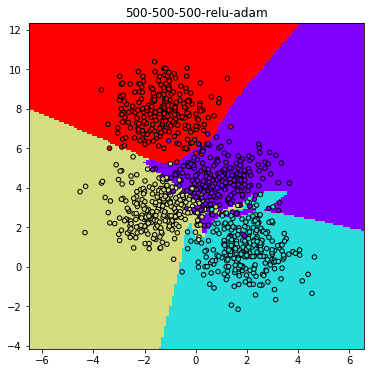

In [102]:
boundary(model8, name8)

- Om het effect duidelijk te maken werden hier 500 neuronen per layer gebruikt ipv 20.
- het model vertoont overfitting: 
    - validation loss is significatn hoger dan training loss
    - accuracy >95% maar de validatie accuracy wordt kleiner --> het model kan minder goed generaliseren op de data waarop het niet getraind werd. 
    - ook de accuracy op de test set is lager dan bij het kleinere netwerk.
    - de boundary van de lichtblauwe klasse vertoont duidelijk een aantal grillige uitstulpingen, met een paar paarse 'eilanden' tussen geel en blauw. Dit is een heel complexe boundary geworden.

## 5. Meer hidden layers

Figure(864x432)


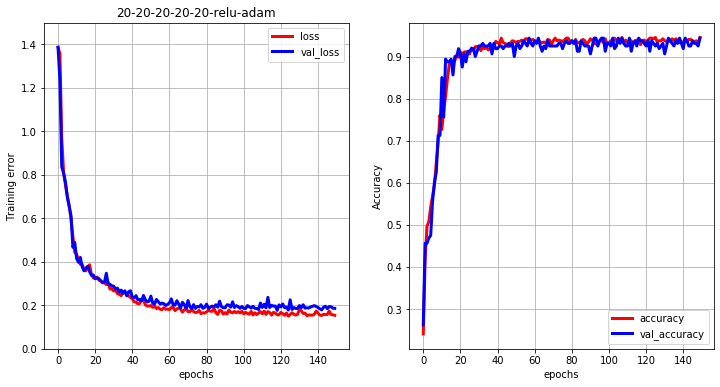

In [105]:
# 5 layers
layers = [ ['dense', 20], ['dense', 20], 
           ['dense', 20], ['dense', 20], 
           ['dense', 20], 
         ]

model9, name9 = CreateModel(X_train.shape[1], y_train.shape[1], hidden_layers=layers)
epochs = 150
history9 = model9.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
histplot(history9, name9)  

Figure(864x432)


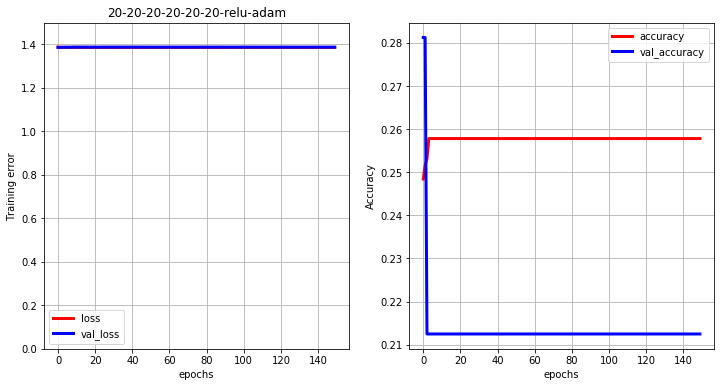

In [106]:
#6 layers : 
layers = [ ['dense', 20], ['dense', 20], 
           ['dense', 20], ['dense', 20], 
           ['dense', 20], ['dense', 20], 
         ]

model10, name10 = CreateModel(X_train.shape[1], y_train.shape[1], hidden_layers=layers)
epochs = 150
history10 = model10.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
histplot(history10, name10)  

Figure(864x432)


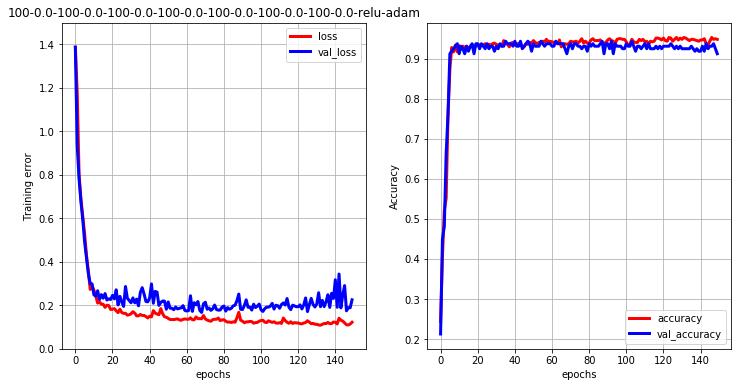

In [117]:
#7 layers : 
do = 0.0
n  = 100
layers = [ ['dense', n], ['dropout', do], ['dense', n], ['dropout', do], ['dense', n], ['dropout', do], 
           ['dense', n], ['dropout', do], ['dense', n], ['dropout', do], 
           ['dense', n], ['dropout', do], ['dense', n], ['dropout', do], 
         ]

model11, name11 = CreateModel(X_train.shape[1], y_train.shape[1], hidden_layers=layers)
epochs = 150
history11 = model11.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
histplot(history11, name11)  

Figure(864x432)


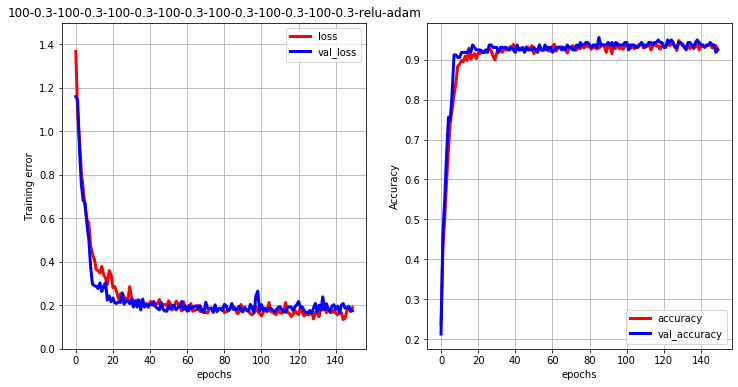

In [118]:
#7 layers : 
do = 0.3
n  = 100
layers = [ ['dense', n], ['dropout', do], ['dense', n], ['dropout', do], ['dense', n], ['dropout', do], 
           ['dense', n], ['dropout', do], ['dense', n], ['dropout', do], 
           ['dense', n], ['dropout', do], ['dense', n], ['dropout', do], 
         ]
model12, name12 = CreateModel(X_train.shape[1], y_train.shape[1], hidden_layers=layers)
epochs = 150
history12 = model12.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
histplot(history12, name12)  

- tot aan 5 layers valt het model nog te trainen met de Adam optimizer. Resultaten gelijkaardig aan een 3 layer netwerk
- voorbeeld met 6 layers geen training mogelijk:
    - er wordt geen optimim meer gevonden, en er is ook niet echt een trend naar een optimum te zien, na 150 epochs
    - de accuracy is dan ook zeer slecht (random weigths, en ze worden blijkbaar niet meer bijgesteld in de richting van een minimum)
- slechts na ook het verhogen van het aantal neuronen per layer worst trainen terug mogelijk
    - vb 7 lagen van 100 neuronen :
        - lichte overfitting waar te nemen
    - Na toevoegen van dropout-rate van 0.3 wordt deze overfitting terug tegengegaan.
        - de uiteingelijke accuracy van het netwerk is wel niet beter dan dit van het kleinere netwerk van in het begin van de opdracht. 


## 6. Batch normalisation

Figure(864x432)


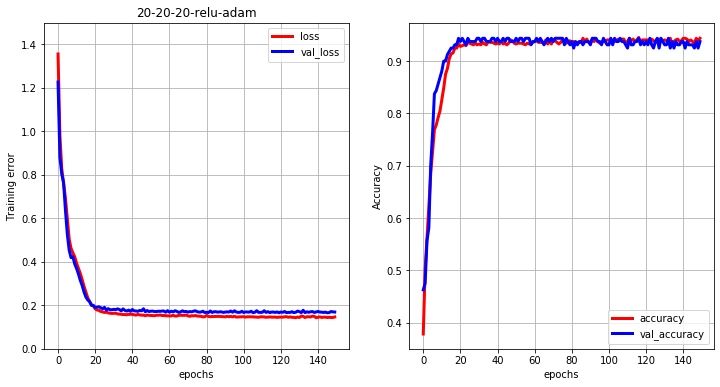

In [129]:
layers = [ ['dense', 20], 
           ['dense', 20], 
           ['dense', 20],
         ]

model13, name13 = CreateModel(X_train.shape[1], y_train.shape[1], hidden_layers=layers)
epochs = 150
history13 = model13.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
histplot(history13, name13)  

Figure(864x432)


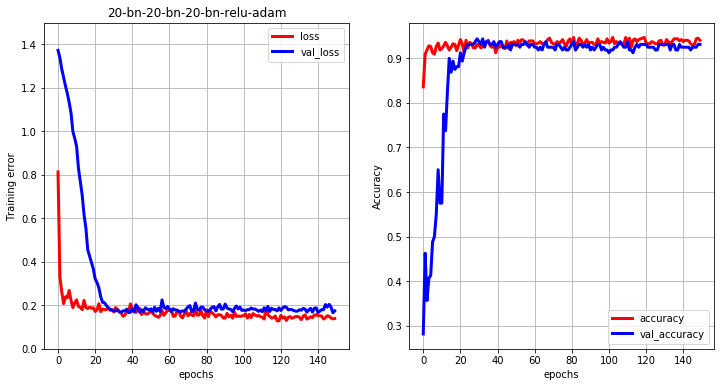

In [130]:
layers = [ ['dense', 20], ['batchnorm'],
           ['dense', 20], ['batchnorm'], 
           ['dense', 20], ['batchnorm'],
         ]

model14, name14 = CreateModel(X_train.shape[1], y_train.shape[1], hidden_layers=layers)
epochs = 150
history14 = model14.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
histplot(history14, name14)  

- bovenstaande voorbeelden zijn zonder en met een batchnormalisatie layer tussen iedere hidden layer paar.
- doordat de training-curve zoieso al iedere keer redelijk verschillend verloopt, kan moeilijk een verschil aangetoond worden, 
    - loss-functie lijkt wel sneller te dalen vanaf het begin, echter de validation loss komt wat later tot het minimum (ongeveer na evenveel epochs als zonder batch-normalisation). 
    - bovenstaande effect ook te zien in de accuracy
- BatchNormalisation is waarschijnlijk belangrijker bij een Signmoid of tanh activation function, omdat deze last kunnen hebben van een 'Vanisching gradient'
    - de curve van deze activatiefuncties worden heel plat bij grotere input waardes --> kleinere gradient = trager trainen
    - als we met de batch-normalisation de weights allemaal terug scaleren blijven de inputs van de activatie-layer in het bruikbaar gebied van de activatie-functie. 
    - Dit wordt hieronder geïllustreerd
        - zonder batchnorm komen we al gauw in een zone waar de loss-functie niet meer sterk daalt, en suboptimaal lijkt (misschien na heel lang trainen bekomen we ook een goed resultaat)
        - met batch norm wordt het minimum snel bereikt.

Figure(864x432)


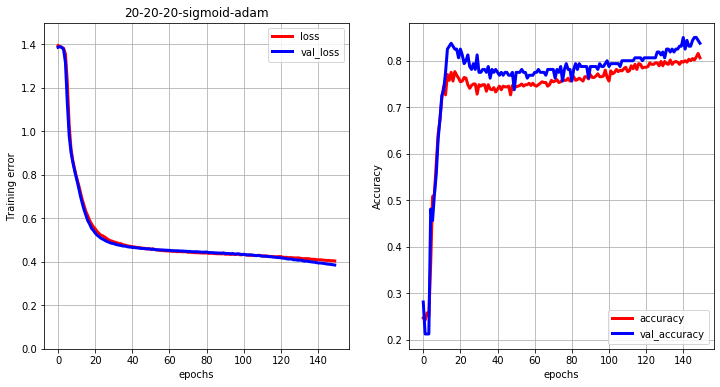

In [133]:
#sigmoid activatie zonder batchnormalisation
layers = [ ['dense', 20], 
           ['dense', 20], 
           ['dense', 20],
         ]

model15, name15 = CreateModel(X_train.shape[1], y_train.shape[1], hidden_layers=layers, activation='sigmoid')
epochs = 150
history15 = model15.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
histplot(history15, name15)  

Figure(864x432)


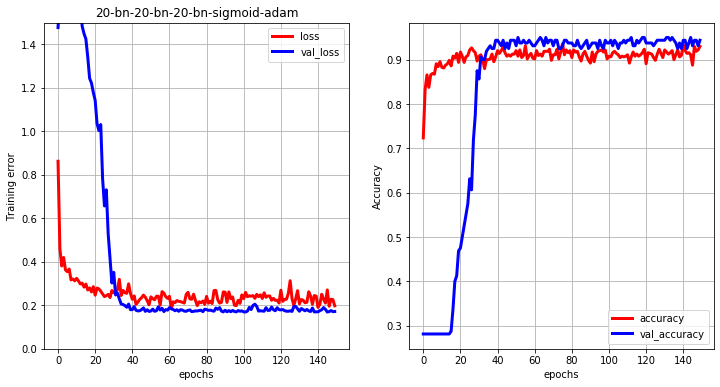

In [135]:
#sigmoid activatie met batchnormalisation
layers = [ ['dense', 20], ['batchnorm'],
           ['dense', 20], ['batchnorm'],
           ['dense', 20], ['batchnorm'],
         ]

model16, name16 = CreateModel(X_train.shape[1], y_train.shape[1], hidden_layers=layers, activation='sigmoid')
epochs = 150
history16 = model16.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
histplot(history16, name16)  

## 7. Andere activatie functies

- bovenstaand reeds gebruikt: 
    - relu : default to use in practically all hidden layers
    - sigmoid : signs of vanashing gradient, zelfs bij een netwerkje met slechts 3 layers en gescalleerde data
    - tanh : hieronder te zien : beter dan sigmoid, en lijkt even goed te werken op het basismodel als relu.
        - los en accuracy zijn na trainen gelijkaardig aan de relu-versie.
        - de logistische sigmoid zet alle negatieve waardes om in positieve. Tanh doet dit niet.
        - tanh heeft een breder bereik op de x-as, het vanishing gradient probleem zal dus wat later optreden (als de input van de activatie-layer groter is). (tanh(x) = 2 sigmoid(2x) - 1)

Figure(864x432)


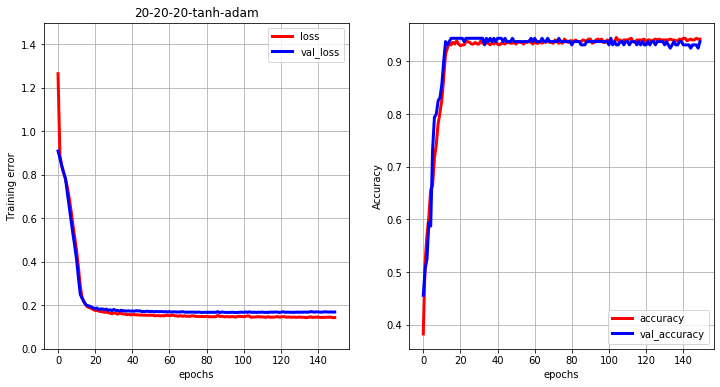

In [137]:
#tanh activatie zonder batchnormalisation
layers = [ ['dense', 20], 
           ['dense', 20], 
           ['dense', 20],
         ]

model17, name17 = CreateModel(X_train.shape[1], y_train.shape[1], hidden_layers=layers, activation='tanh')
epochs = 150
history17 = model17.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
histplot(history17, name17)  

## 8. Andere kernel initialisers

Figure(864x432)


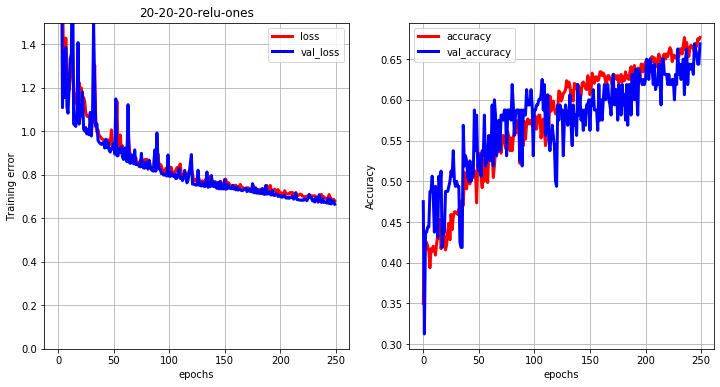

In [148]:
#kernel initialiser : ones
layers = [ ['dense', 20], 
           ['dense', 20], 
           ['dense', 20],
         ]

model18, name18 = CreateModel(X_train.shape[1], y_train.shape[1], hidden_layers=layers, initializer = Ones(), extra_name='ones')
epochs = 250
history18 = model18.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
histplot(history18, name18)  

Figure(864x432)


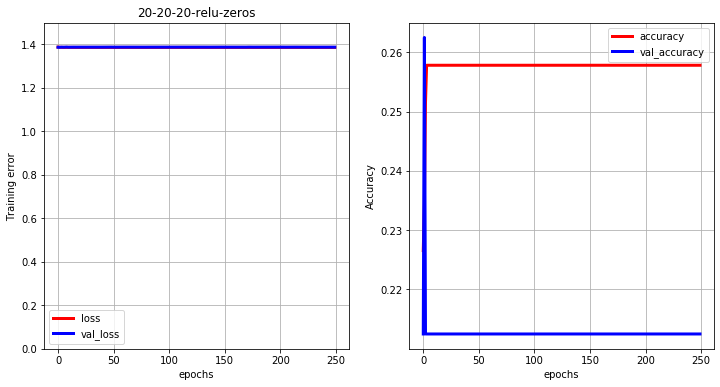

In [149]:
#kernel initialiser : zeros
layers = [ ['dense', 20], 
           ['dense', 20], 
           ['dense', 20],
         ]

model19, name19 = CreateModel(X_train.shape[1], y_train.shape[1], hidden_layers=layers, initializer = Zeros(), extra_name='zeros')
epochs = 250
history19 = model19.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
histplot(history19, name19)  

Figure(864x432)


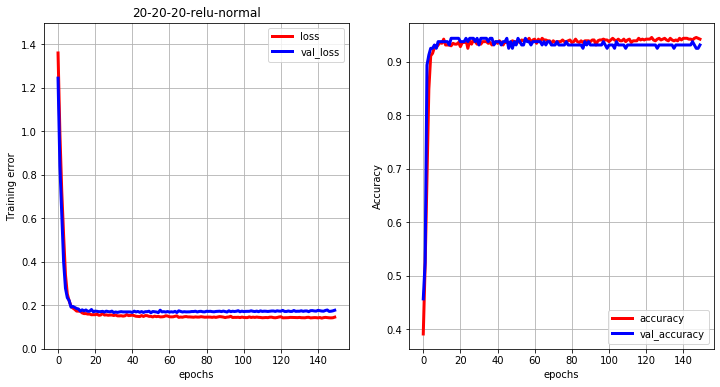

In [151]:
#kernel initialiser : RandomNormal
layers = [ ['dense', 20], 
           ['dense', 20], 
           ['dense', 20],
         ]

model20, name20 = CreateModel(X_train.shape[1], y_train.shape[1], hidden_layers=layers, initializer = RandomNormal(), extra_name='normal')
epochs = 150
history20 = model20.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
histplot(history20, name20)  

- RandomUniform() initialiser werd tot nu toe reeds altijd gebruikt
- test met Ones() : alle weights initieel op 1
    - trainen gaat traag, en het minimum lijkt niet bereikt te zullen worden
- test met Zeros() : alle weights initieel op 0
    - kan niet getrained worden omdat de backprop niet werkt --> voor backprop wordt de gradient vermenigvuldigd met ve weigth --> resultaat = 0, en alle weigths blijven op 0
 - RandomNormal() : niet uniform random kiezen, maar uit een normale distributie
    - ook goede training resultaten te zien in de curves (misschien zelfs beter dan de RandomUniform in dit geval)

## 9 Hyperparameter tuning

Model setup :
- KerasClassifier met functie om model op te bouwen (=recuperatie van functie die hierbove reeds veelvuldig gebruikt werd)
- 8-fold cross-validatie --> 12.5% van de dat wordt gebruikt om de hyper-parameter-performance af te checken, 87.5% om te trainen
- echter om Earlystopping te doen wordt nog eens 10% van de 87.5% afgesnoept om een validatie-loss van de individuele gevallen te bepalen om een early stopping te verwezenlijken met de callback.


- hier werd de grootte van het netwerk (aantal neuronen per layer, en aantal layers), en een dropout niveau in de grid-search gestopt. Nog meer parameters toevoegen zou het aantal te trainen netwerken compleet doen exploderen. Dus hier op deze parameters beperkt. Met dit kleine netwerk, en beperkte dataset zal het resultaat niet zoveel veranderen. 

Resultaat :

- Een performantie op de test-set van 90% wordt reeds gehaald bij een klein netwerk van 5 neuronen in 2 layers!
    - betere performantie lijkt niet echt haalbaar op de test-set als de samples zowat random door elkaar lopen aan de overgangen tussen de blobs.
    - er werd nog eens apart geverifieerd onderaan met een gelijkaardig netwerk. 

In [237]:
def create_model(layers=3, neurons=10, dropout=0.0, inputs=X_train.shape[1], outputs=y_train.shape[1]):
    layers = [ *([['dense', neurons], ['dropout', dropout]] * layers) ]
    model, name = CreateModel(inputs, outputs, hidden_layers=layers)
    return model

#create_model_2 = partial(create_model, inputs=, outputs=y_train.shape[1])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1) 
model_builder = KerasClassifier(build_fn=create_model, epochs =100, verbose=0)

param_grid = {
              'layers'  : [2, 3, 4, 5],
              'neurons' : [5, 10, 20, 30, 40],
              'dropout' : [0.0, 0.1, 0.2], #, 0.3, 0.4, 0.5]}
             }

grid = GridSearchCV(estimator=model_builder, param_grid = param_grid, verbose=2, cv=8, n_jobs=4, iid=True, return_train_score=True)
#fit_params={'callbacks':[EarlyStopping(monitor='val_loss', mode='min', verbose=1)], 'validation_split':0.1, 'verbose':0}

In [238]:
grid.fit(X_train, y_train, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience = 5)]);
#some overflow text comes into output box for some... reason? 

Fitting 8 folds for each of 60 candidates, totalling 480 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   25.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.2min
/home/svhb/.local/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 480 out of 480 | elapsed:  7.0min finished


In [239]:
grid.best_params_

{'dropout': 0.0, 'layers': 2, 'neurons': 5}

In [245]:
# Testen met test set
y_pred = grid.predict(X_test)
#print(y_pred)

print(classification_report(y_test, y_pred))
cf = confusion_matrix(y_test, y_pred)

print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

              precision    recall  f1-score   support

           0       0.81      0.77      0.79        44
           1       0.96      0.96      0.96        51
           2       0.86      0.88      0.87        48
           3       0.95      0.96      0.96        57

   micro avg       0.90      0.90      0.90       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.90      0.90      0.90       200

[[34  2  6  2]
 [ 1 49  1  0]
 [ 5  0 42  1]
 [ 2  0  0 55]]
90.0


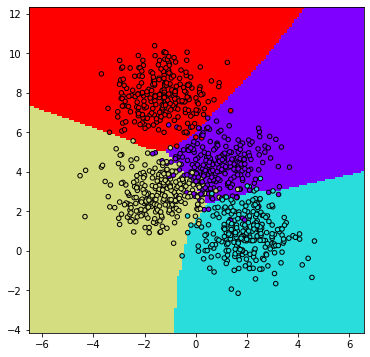

In [253]:
boundary(grid.best_estimator_, "")

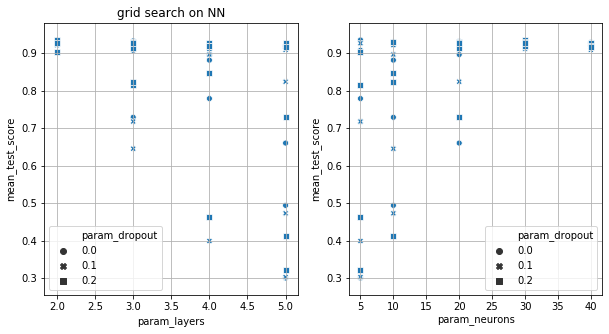

In [241]:
#make a dataframe from the results to visualise the hyperparameters vs accuracy
score = pd.DataFrame(grid.cv_results_)
#display(score)

fig, axes = plt.subplots(1,2)
fig.set_size_inches((10,5))
sns.scatterplot(ax=axes[0], x="param_layers", y='mean_test_score', hue=None,  data=score, style='param_dropout')
sns.scatterplot(ax=axes[1], x="param_neurons", y='mean_test_score', hue=None,  data=score, style='param_dropout')

axes[0].set_title("grid search on NN")
axes[0].grid(True,which="both",ls="-")
axes[1].grid(True,which="both",ls="-")
    
#plt.savefig(filename+'.png')

Figure(864x432)


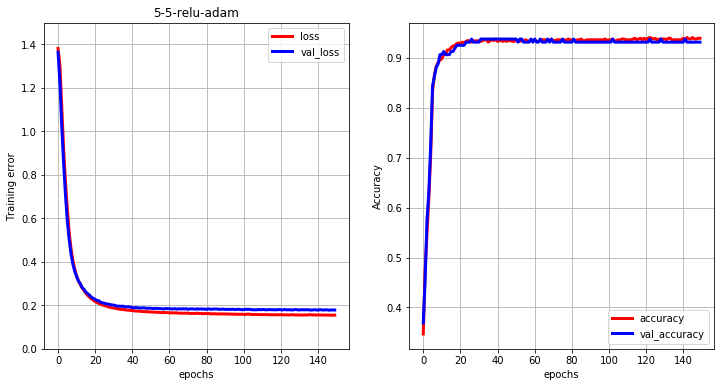

In [242]:
#doublecheck result
layers = [ ['dense', 5], 
           ['dense', 5], 
         ]

model21, name21 = CreateModel(X_train.shape[1], y_train.shape[1], hidden_layers=layers)
epochs = 150
history21 = model21.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
histplot(history21, name21)  

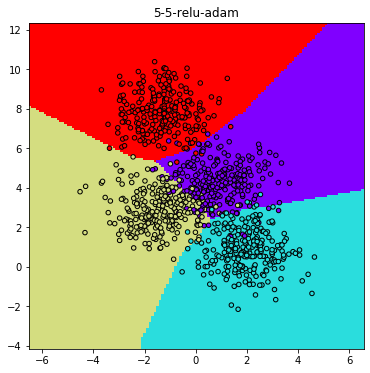

In [244]:
boundary(model21, name21)